In [158]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt.solvers import qp
from cvxopt import matrix

#### 一、定义数据集类

In [159]:
class Dataset:
    def __init__(self, means1=[-5, 0], means2=[0, 5]):
        self._rand_sample(means1, means2)

    def _rand_sample(self, means1, means2):
        means1 = np.array(means1)
        means2 = np.array(means2)
        covar = np.array([1, 0, 0, 1]).reshape(2,2)
        x1 = np.random.multivariate_normal(means1, covar, size=200)
        x2 = np.random.multivariate_normal(means2, covar, size=200)
        y1 = np.ones((200, 1))
        y2 = np.ones((200, 1)) * -1
        #y2 = np.ones((200, 1)) * -1
        self._split(x1, y1, x2, y2)

    def _split(self, x1, y1, x2, y2):
        num1 = x1.shape[0]
        train_num1 = int(num1 * 0.8)
        num2 = x2.shape[0]
        train_num2 = int(num2 * 0.8)

        self.x_train = np.concatenate((x1[:train_num1],x2[:train_num2]),axis=0)
        self.y_train = np.concatenate((y1[:train_num1],y2[:train_num2]),axis=0)
        self.x_test = np.concatenate((x1[train_num1:],x2[train_num2:]),axis=0)
        self.y_test = np.concatenate((y1[train_num1:],y2[train_num2:]),axis=0)

#### 二、SVM模型实现

Hinge Loss

In [160]:
def hinge_loss(y, yhat):
    batch_size = y.shape[0]

    loss = 1-y*yhat
    loss = np.clip(loss, a_min=0, a_max=None)

    return np.sum(loss,axis=0)/batch_size

##### 1. 线性支持向量机

In [161]:
class SVM:
    def __init__(self, dimension=2):
        self.dimension = dimension
        self.w = np.zeros((dimension+1,1))  ## 增广化

    def quadratic_programming(self, x, y):
        ## 使用二次规划求解
        n, dimension = x.shape
        if not dimension == self.dimension:
            raise

        Q = np.eye(self.dimension+1)
        Q[0][0] = 0

        p = np.zeros((self.dimension+1,1))
        expand_dims = np.ones((n,1))
        A = -y * np.concatenate((expand_dims, x), axis=1)
        c = -1 * np.ones((n,1))

        Q = matrix(Q)
        p = matrix(p)
        A = matrix(A)
        c = matrix(c)

        slv = qp(Q, p, A, c)['x']
        self.w = np.array(slv).reshape(dimension+1,1)

    def train(self, x, y, epoch=10, lr=0.1):
        ## 梯度下降求解
        '''
        Args: 
             x : `array_like` (n, dimension)
             y : `array_like` (n, 1)
             mode: 'qp': quadratic programming
                   'gd': gradient descent
        '''
        n, dimension = x.shape
        if not dimension == self.dimension:
            raise
        expand_dims = np.ones((n,1))
        x = np.concatenate((expand_dims, x), axis=1) ## 增广化
        
        losses = []
        for n_epoch in range(epoch):

            yhat = np.matmul(x,self.w)
            loss = hinge_loss(y, yhat)
            losses.append(loss)
            grad = self._caculate_grad(x, y, yhat)
            self.w -= lr * grad

            print('epoch: %i/%i  loss: %.2f'%(n_epoch+1, epoch, loss))

        return losses


    def _caculate_grad(self, x, y, yhat):
        index = np.where((1 - y * yhat) < 0)[0]
        grad = -y * x
        grad[index] = 0
        grad = np.sum(grad, axis=0)

        return grad.reshape(self.dimension+1, 1)

    def eval(self, x, y):
        n, dimension = x.shape
        if not dimension == self.dimension:
            raise
        expand_dims = np.ones((n,1))
        x = np.concatenate((expand_dims, x), axis=1) ## 增广化

        yhat = np.matmul(x, self.w)
        yhat = np.sign(yhat)
        correct = len(np.where(yhat == y)[0])

        print('测试集准确率 %.2f'%(correct/n))

##### 2. 对偶支持向量机

In [162]:
class DualSVM(SVM):
    def __init__(self, dimension=2):
        self.dimension = dimension
        self.w = np.zeros((dimension,1))  ## 不做增广化
        self.b = 0

    def quadratic_programming(self, z, y, epsilon=1e-8):
        '''
        Args:
            z: (n, dim) features after non-linear transform
            y: (n, 1) labels
            n: dimension after non-linear transform (not include constant 1)
        Description:
            solve convex optim problem
            min { 1/2 * u.T * Q * u + p.T * u }
            s.t: A * u <= C & R * u = v
            
            Dual SVM: the dimension of param are irrelated to ~d
            u: (n, 1)
            Q: (n, n)
            p: (n, 1)
            A: (n, n)
            C: (n, 1)
            R: (1, n)
            v: (1, 1)
        '''
        n, dimension = z.shape
        if not dimension == self.dimension:
            raise

        Q = np.matmul(y,y.T) * np.matmul(z, z.T)
        p = -1 * np.ones((n,1))
        A = -1 * np.eye(n)
        c = np.zeros((n,1))
        R = y.T
        v = np.zeros((1,1))

        Q = matrix(Q)
        p = matrix(p)
        A = matrix(A)
        c = matrix(c)
        R = matrix(R)
        v = matrix(v)

        alpha = np.array(qp(Q, p, A, c, R, v)['x']) ## (n, 1)
        idx = np.where(alpha>epsilon)[0]

        self.w = np.sum(alpha * y * z, axis=0).reshape(dimension, 1)

        self.b = y[idx[0]] - np.matmul(z[idx[0]], self.w)

        self.support_vector = z[idx]
        self.support_vector_y = y[idx]

    def eval(self, x, y):
        n, dimension = x.shape
        if not dimension == self.dimension:
            raise

        yhat = np.matmul(x, self.w) + self.b
        yhat = np.sign(yhat)
        correct = len(np.where(yhat == y)[0])

        print('测试集准确率 %.2f'%(correct/n))

##### 3.核函数支持向量机

In [163]:
class KernelSVM(SVM):
    def __init__(self, nonlinear=2, zeta=1, gamma=1, gauss=False):
        '''
        Args: dimension: dim before non-linear transform
              nonlinear: nonlinear transform order
              gauss: use gauss kernel (infinity order transform)
        '''
        self.nonlinear = nonlinear
        self.zeta = zeta
        self.gamma = gamma
        self.gauss = gauss

    def quadratic_programming(self, x, y):
        ##  
        ## NOTE: input of dual-svm is features after non-linear transfrom
        ##       input of kernel is orgin features
        ##
        n, dimension = x.shape

        ## guass kernel
        if self.gauss:
            kernel = self._caculate_gauss_kernel(x, x)

        ## polyomial kernel
        else:
            kernel = self._caculate_kernel(x, x)

        Q = np.matmul(y,y.T) * kernel
        p = -1 * np.ones((n,1))
        A = -1 * np.eye(n)
        c = np.zeros((n,1))
        R = y.T
        v = np.zeros((1,1))

        Q = matrix(Q)
        p = matrix(p)
        A = matrix(A)
        c = matrix(c)
        R = matrix(R)
        v = matrix(v)

        alpha = np.array(qp(Q, p, A, c, R, v)['x']) ## (n, 1)
        idx = np.where(alpha>1e-8)[0][0]

        ## only get support vector index 
        idx = np.where(alpha>1e-6)[0] ## ToDo: adaptive epsilon than manual-choose
        self.alpha = alpha[idx]
        self.sv = x[idx]
        self.sv_y = y[idx]

        x_query, y_query = self.sv[0].reshape(1,-1), self.sv_y[0]

        if self.gauss:
            kernel_value = self._caculate_gauss_kernel(x_query, self.sv)

        else:
            kernel_value = self._caculate_kernel(x_query, self.sv)

        self.b = y_query - np.sum(self.alpha * self.sv_y * kernel_value)

    def __call__(self, x):
        n, dimension = x.shape

        if self.gauss:
            kernel_value = self._caculate_gauss_kernel(x, self.sv)
        else:
            kernel_value = self._caculate_kernel(x, self.sv)

        yhat = np.sum(self.alpha * self.sv_y * kernel_value, axis=0) + self.b
        yhat = np.sign(yhat).reshape(n,1)

        return yhat

    def eval(self, x, y):
        n, dimension = x.shape

        if self.gauss:
            kernel_value = self._caculate_gauss_kernel(x, self.sv)
        else:
            kernel_value = self._caculate_kernel(x, self.sv)
        yhat = np.sum(self.alpha * self.sv_y * kernel_value, axis=0) + self.b
        yhat = np.sign(yhat).reshape(n,1)
        correct = len(np.where(yhat == y)[0])

        print('测试集准确率 %.2f'%(correct/n))

    def _caculate_kernel(self, x, sv_x):
        n, dimension1 = sv_x.shape
        m, dimension2 = x.shape
        assert(dimension1 == dimension2)

        kernel_value = np.power(self.zeta + self.gamma * np.matmul(sv_x, x.T), self.nonlinear)

        return kernel_value.reshape(n,m)

    def _caculate_gauss_kernel(self, x, sv_x):
        n, dimension1 = sv_x.shape
        m, dimension2 = x.shape
        assert(dimension1 == dimension2)
        graph1 = np.repeat(np.expand_dims(x, axis=0), n, axis=0)
        graph2 = np.repeat(np.expand_dims(sv_x, axis=0), m, axis=0).transpose(1,0,2)


        kernel_value = np.exp(-self.gamma * np.linalg.norm(graph1 - graph2, axis=-1))

        return kernel_value

#### 三、测试a
##### 1. 生成数据集并可视化

x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


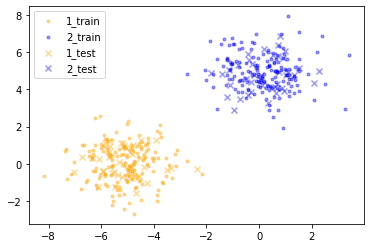

In [164]:
data1 = Dataset()
x_train = data1.x_train
y_train = data1.y_train
x_test = data1.x_test
y_test = data1.y_test

print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

##### 2.线性支持向量机
使用二次规划求解的线性支持向量机计算最大间隔面,并用测试机测试准确率

     pcost       dcost       gap    pres   dres
 0:  3.3710e-02  5.9295e+01  9e+02  2e+00  2e+03
 1:  2.3757e-01 -1.5348e+02  2e+02  4e-01  4e+02
 2:  4.6891e-01 -9.7868e+01  1e+02  1e-01  2e+02
 3:  5.3020e-01 -1.6130e+00  2e+00  3e-03  3e+00
 4:  4.0754e-01  2.5316e-01  2e-01  6e-16  3e-15
 5:  3.8323e-01  3.4620e-01  4e-02  5e-16  7e-15
 6:  3.7860e-01  3.7635e-01  2e-03  5e-16  2e-15
 7:  3.7847e-01  3.7845e-01  2e-05  6e-16  2e-15
 8:  3.7847e-01  3.7847e-01  2e-07  6e-16  4e-15
Optimal solution found.
w: [[-0.74103689]
 [-0.45585122]]
b: [-0.84155933]
测试集准确率 1.00


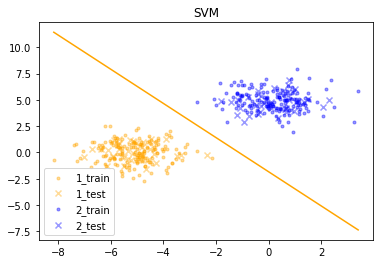

In [165]:
model1 = SVM(dimension=2)
model1.quadratic_programming(x_train, y_train)

b, w = model1.w[0], model1.w[1:]
print('w: {}'.format(w))
print('b: {}'.format(b))
model1.eval(x_test, y_test)


c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('SVM')
plt.show()

##### 3. 对偶支持向量机
对偶支持向量机将计算复杂度与特征维数相关转化为了与训练样本个数相关。通过alpha取值可明确支持向量，在结果中可视化。

     pcost       dcost       gap    pres   dres
 0: -2.1879e+01 -3.8392e+01  9e+02  3e+01  2e+00
 1: -1.7445e+01 -6.8152e+00  2e+02  6e+00  4e-01
 2: -1.1498e+01 -2.1662e+00  1e+02  2e+00  1e-01
 3: -5.2693e-01 -5.3290e-01  2e+00  4e-02  3e-03
 4: -2.5316e-01 -4.0754e-01  2e-01  8e-17  4e-15
 5: -3.4620e-01 -3.8323e-01  4e-02  8e-17  2e-15
 6: -3.7635e-01 -3.7860e-01  2e-03  8e-17  3e-15
 7: -3.7845e-01 -3.7847e-01  2e-05  6e-17  3e-15
 8: -3.7847e-01 -3.7847e-01  2e-07  8e-17  3e-15
Optimal solution found.
w: [[-0.74103689]
 [-0.45585122]]
b: [-0.84155933]
测试集准确率 1.00


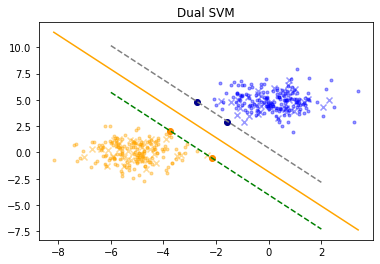

In [166]:
model2 = DualSVM(dimension=2)
model2.quadratic_programming(x_train, y_train)

sv, sv_y = model2.support_vector, model2.support_vector_y
b, w = model1.w[0], model1.w[1:]
print('w: {}'.format(w))
print('b: {}'.format(b))
model2.eval(x_test, y_test)

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')


xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')

x = np.linspace(-6, 2, 100)
pos_b = - w[0] * pos_sv[0][0] - w[1] * pos_sv[0][1]
pos_f = -(w[0] * x+pos_b) / w[1]
neg_b = - w[0] * neg_sv[0][0] - w[1] * neg_sv[0][1]
neg_f = -(w[0] * x+neg_b) / w[1]

plt.plot(x, pos_f, '--', c='green')
plt.plot(x, neg_f, '--', c='gray')

#plt.legend(handles=[c1, c3, c2, c4, c5, c6],labels=['1_train','1_test','2_train','2_test','1_sv','2_sv'],loc='best')
plt.title('Dual SVM')
plt.show()

##### 4.核函数支持向量机
核函数支持向量机利用核函数将数据非线性变换，故分类面不再是线性，首先定义画非线性分类面函数

In [167]:
def plot_decision_boundary(x, pred_func, h=0.1):  

    ## 设定最大最小值，边缘填充  
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5  
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5  

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  

    ## 预测 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])  
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap='BuGn')

4.1 用四次多项式的高斯核,可视化支持向量和决策面

     pcost       dcost       gap    pres   dres
 0: -5.3916e+00 -8.9736e+00  6e+02  2e+01  2e+00
 1: -3.8458e+00 -6.4486e-01  4e+01  2e+00  1e-01
 2: -3.2445e-01 -9.7666e-02  3e+00  1e-01  9e-03
 3: -5.1490e-02 -3.2197e-02  8e-01  2e-02  2e-03
 4: -2.0607e-02 -1.3926e-02  1e-01  4e-03  3e-04
 5: -1.7458e-02 -8.0575e-03  5e-02  1e-03  1e-04
 6: -3.8520e-03 -2.5714e-03  7e-03  1e-04  1e-05
 7: -2.9477e-03 -2.4528e-03  5e-03  8e-05  6e-06
 8: -2.4367e-03 -2.2869e-03  3e-03  5e-05  4e-06
 9: -2.4225e-03 -1.9398e-03  3e-03  3e-05  3e-06
10: -2.3498e-03 -1.4835e-03  1e-03  1e-05  1e-06
11: -1.3621e-03 -9.7363e-04  3e-04  3e-06  2e-07
12: -1.1914e-03 -9.4242e-04  3e-04  2e-06  2e-07
13: -8.7603e-04 -9.1755e-04  7e-05  8e-08  6e-09
14: -9.1517e-04 -9.1606e-04  1e-06  5e-10  4e-11
15: -9.1603e-04 -9.1604e-04  1e-08  5e-12  4e-13
Optimal solution found.
测试集准确率 1.00


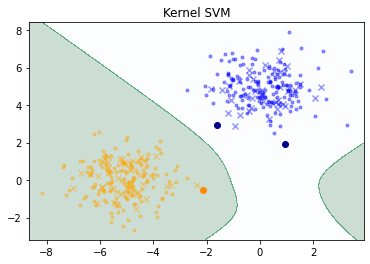

In [168]:
model3 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=False)
model3.quadratic_programming(x_train, y_train)

sv, sv_y = model3.sv, model3.sv_y
model3.eval(x_test, y_test)

## 画决策边界
plot_decision_boundary(x_train, model3, h=0.01)

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')

#plt.legend(handles=[c1, c3, c2, c4, c5, c6],labels=['1_train','1_test','2_train','2_test','1_sv','2_sv'],loc='best')
plt.title('Kernel SVM')
plt.show()

4.2 使用高斯核函数支持向量机

     pcost       dcost       gap    pres   dres
 0: -7.5045e+00 -2.3395e+01  2e+01  2e-16  1e+00
 1: -7.8237e+00 -9.8004e+00  2e+00  2e-15  2e-01
 2: -8.0327e+00 -8.3625e+00  3e-01  5e-15  2e-02
 3: -8.0542e+00 -8.0965e+00  4e-02  6e-15  2e-03
 4: -8.0583e+00 -8.0648e+00  6e-03  6e-15  8e-05
 5: -8.0590e+00 -8.0599e+00  8e-04  5e-15  7e-06
 6: -8.0592e+00 -8.0593e+00  1e-04  1e-15  5e-07
 7: -8.0592e+00 -8.0592e+00  1e-05  5e-16  3e-08
 8: -8.0592e+00 -8.0592e+00  7e-07  2e-15  1e-09
Optimal solution found.
测试集准确率 1.00
(10, 2)


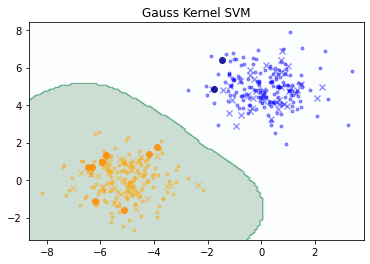

In [169]:
model4 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=True)
model4.quadratic_programming(x_train, y_train)

sv, sv_y = model4.sv, model4.sv_y
model4.eval(x_test, y_test)

plot_decision_boundary(x_train, model4, h=0.1)

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

## 选取alpha最大n个的作为支撑向量
alpha = model4.alpha
idx = np.argsort(alpha, axis=0)[:10].squeeze()
sv = sv[idx]
sv_y = sv_y[idx]
print(sv.shape)
pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=0.8, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=0.8, marker='o', c='darkblue')

#plt.legend(handles=[c1, c3, c2, c4, c5, c6],labels=['1_train','1_test','2_train','2_test','1_sv','2_sv'],loc='best')
plt.title('Gauss Kernel SVM')
plt.show()

#### 四、测试b

#### 1.生成新数据集

x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


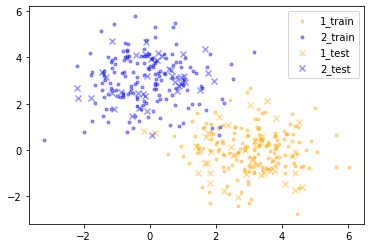

In [170]:
data2 = Dataset(means1=[3, 0], means2=[0, 3])
x_train = data2.x_train
y_train = data2.y_train
x_test = data2.x_test
y_test = data2.y_test

print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

##### 2.线性支持向量机
使用二次规划求解的线性支持向量机计算最大间隔面,显然由于数据不是线性可分的，线性支持向量机无法进行分类

In [171]:
model1 = SVM(dimension=2)
model1.quadratic_programming(x_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  6.9502e-02  1.7199e+02  1e+03  2e+00  1e+03
 1:  2.8431e-01 -1.5121e+02  1e+03  2e+00  1e+03
 2:  2.5276e-01  3.1508e+01  1e+03  2e+00  9e+02
 3:  2.0371e-01  7.3425e+02  1e+03  1e+00  8e+02
 4:  3.6684e-03  4.5213e+03  1e+03  1e+00  7e+02
 5:  3.0982e-04  1.3933e+04  2e+03  1e+00  6e+02
 6:  5.0682e-04  1.0215e+05  3e+03  1e+00  6e+02
 7:  9.9624e-05  2.1242e+06  3e+04  1e+00  6e+02
 8:  6.9944e-07  1.5136e+08  2e+05  1e+00  6e+02
 9:  8.5710e-09  1.0657e+11  2e+07  1e+00  6e+02
10:  2.8260e-12  7.3698e+14  2e+09  1e+00  6e+02
11:  2.8733e-16  2.8266e+20  7e+12  1e+00  3e+05
12:  2.8736e-20  1.0753e+28  3e+18  1e+00  1e+13
13:  2.0833e-21  3.4933e+37  1e+27  1e+00  3e+22
14:  8.1231e-22  3.0267e+47  8e+36  1e+00  2e+32
15:  2.5851e-22  2.4463e+57  5e+46  1e+00  2e+42
16:  2.1650e-22  3.0129e+66  6e+55  1e+00  3e+51
17:  2.7337e-22  3.5936e+74  7e+63  1e+00  2e+59
18:  2.4163e-22  1.6847e+83  3e+72  1e+00  1e+68
19:  2.9277e-22  1.85

ValueError: domain error

##### 3.核函数支持向量机
核函数的引进使得SVM具有非线性分类的能力，首先使用四次核函数

     pcost       dcost       gap    pres   dres
 0: -3.1260e+01 -7.0833e+01  9e+02  2e+01  2e+00
 1: -7.2940e+01 -1.0643e+02  6e+02  1e+01  1e+00
 2: -4.0004e+02 -5.6749e+02  7e+02  1e+01  1e+00
 3: -1.1182e+03 -1.3810e+03  7e+02  1e+01  1e+00
 4: -1.3116e+03 -1.6091e+03  7e+02  1e+01  1e+00
 5: -2.9899e+03 -3.4629e+03  9e+02  1e+01  1e+00
 6: -6.4917e+03 -7.2759e+03  1e+03  1e+01  1e+00
 7: -8.2981e+03 -9.2558e+03  2e+03  1e+01  1e+00
 8: -2.6046e+04 -2.8069e+04  3e+03  1e+01  1e+00
 9: -4.4516e+04 -4.7577e+04  5e+03  1e+01  1e+00
10: -5.9445e+04 -6.3260e+04  7e+03  1e+01  1e+00
11: -9.3037e+04 -9.8425e+04  1e+04  1e+01  1e+00
12: -9.7695e+04 -1.0331e+05  1e+04  1e+01  1e+00
13: -1.5822e+05 -1.6652e+05  2e+04  1e+01  1e+00
14: -1.8428e+05 -1.9329e+05  2e+04  1e+01  1e+00
15: -1.8868e+05 -1.9715e+05  3e+04  1e+01  1e+00
16: -1.7826e+05 -1.8335e+05  4e+04  1e+01  1e+00
17: -1.6478e+05 -1.6428e+05  6e+04  1e+01  1e+00
18: -1.3724e+05 -1.2737e+05  9e+04  9e+00  9e-01
19: -1.2447e+05 -1.09

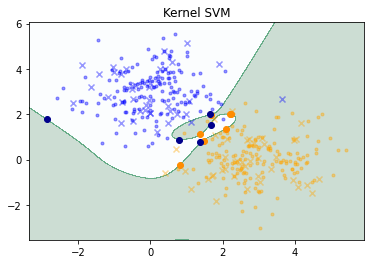

In [ ]:
model3 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=False)
model3.quadratic_programming(x_train, y_train)

sv, sv_y = model3.sv, model3.sv_y
model3.eval(x_test, y_test)

## 画决策边界
plot_decision_boundary(x_train, model3, h=0.01)

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')

#plt.legend(handles=[c1, c3, c2, c4, c5, c6],labels=['1_train','1_test','2_train','2_test','1_sv','2_sv'],loc='best')
plt.title('Kernel SVM')
plt.show()

再使用高斯核函数

     pcost       dcost       gap    pres   dres
 0: -1.7952e+01 -6.1120e+01  7e+02  2e+01  2e+00
 1: -2.8079e+01 -9.2412e+01  3e+02  6e+00  7e-01
 2: -2.6758e+01 -1.0749e+02  8e+01  6e-15  3e-15
 3: -4.6804e+01 -6.3291e+01  2e+01  4e-14  2e-15
 4: -5.0438e+01 -5.4945e+01  5e+00  3e-14  2e-15
 5: -5.1539e+01 -5.2533e+01  1e+00  9e-15  3e-15
 6: -5.1793e+01 -5.2018e+01  2e-01  2e-14  3e-15
 7: -5.1853e+01 -5.1898e+01  4e-02  4e-14  2e-15
 8: -5.1867e+01 -5.1875e+01  7e-03  5e-15  2e-15
 9: -5.1870e+01 -5.1871e+01  1e-03  6e-14  2e-15
10: -5.1871e+01 -5.1871e+01  2e-04  3e-14  2e-15
11: -5.1871e+01 -5.1871e+01  2e-05  2e-14  2e-15
Optimal solution found.
测试集准确率 0.97


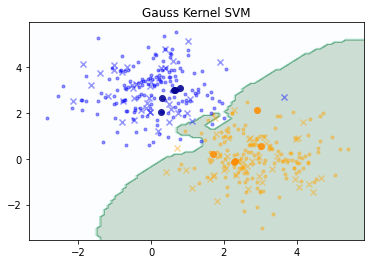

In [ ]:
model4 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=True)
model4.quadratic_programming(x_train, y_train)

sv, sv_y = model4.sv, model4.sv_y
model4.eval(x_test, y_test)

plot_decision_boundary(x_train, model4, h=0.1)

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='orange')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

## 选取alpha最大n个的作为支撑向量
alpha = model4.alpha
idx = np.argsort(alpha, axis=0)[:10].squeeze()
sv = sv[idx]
sv_y = sv_y[idx]
pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=0.8, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=0.8, marker='o', c='darkblue')

#plt.legend(handles=[c1, c3, c2, c4, c5, c6],labels=['1_train','1_test','2_train','2_test','1_sv','2_sv'],loc='best')
plt.title('Gauss Kernel SVM')
plt.show()

#### 五、测试c
##### 训练集:
中国与日本的沿海城市的经纬度坐标向量，中国标签为+1, 日本为标签为-1.
##### 测试集: 
钓鱼岛的经纬度坐标向量
##### 要求
用支撑向量机设计分类器，（1）判断钓鱼岛属于哪一类；（2）增加几个非海边城市的经纬度坐标进行训练，判断这些城市是否影响分类结果，是否为支撑向量。


In [ ]:
## 钓鱼岛坐标
XC=[123.28,25.45,1]

## 仅仅使用沿海城市

x1=[119.28,26.08,#福州
121.31,25.03,#台北
121.47,31.23,#上海
118.06,24.27,#厦门
121.46,39.04,#大连
122.10,37.50,#威海
124.23,40.07]#丹东

x2=[129.87,32.75,#长崎
130.33,31.36,#鹿儿岛
131.42,31.91,#宫崎
130.24,33.35,#福冈
133.33,15.43,#鸟取
138.38,34.98,#静冈
140.47,36.37]#水户  

## 添加内陆城市

xp1=[119.28,26.08,#福州
121.31,25.03,#台北
121.47,31.23,#上海
118.06,24.27,#厦门
113.53,29.58,#武汉
104.06,30.67,#成都
116.25,39.54,#北京
121.46,39.04,#大连
122.10,37.50,#威海
124.23,40.07];#丹东

xp2=[129.87,32.75,#长崎
130.33,31.36,#鹿儿岛
131.42,31.91,#宫崎
130.24,33.35,#福冈
136.54,35.10,#名古屋
132.27,34.24,#广岛
139.46,35.42,#东京
133.33,15.43,#鸟取
138.38,34.98,#静冈
140.47,36.37],#水户

x1 = np.array(x1).reshape(-1, 2)
x2 = np.array(x2).reshape(-1, 2)
y1 = np.ones((7,1))
y2 = np.ones((7,1)) * -1

x_train = np.concatenate((x1,x2),axis=0)
y_train = np.concatenate((y1,y2),axis=0)

xp1 = np.array(xp1).reshape(-1, 2)
xp2 = np.array(xp2).reshape(-1, 2)
yp1 = np.ones((10,1))
yp2 = np.ones((10,1)) * -1

xp_train = np.concatenate((xp1,xp2),axis=0)
yp_train = np.concatenate((yp1,yp2),axis=0)

print('x_train: {}  y_train: {}'.format(x_train.shape, y_train.shape))
print('xp_train: {}  yp_train: {}'.format(xp_train.shape, yp_train.shape))

x_train: (14, 2)  y_train: (14, 1)
xp_train: (20, 2)  yp_train: (20, 1)


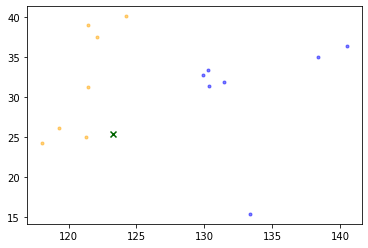

In [ ]:
c1 = plt.scatter(x1[:,0], x1[:,1], alpha=0.5, marker='.', c='orange')
c2 = plt.scatter(x2[:,0], x2[:,1], alpha=0.5, marker='.', c='blue')
c3 = plt.scatter(XC[0], XC[1], alpha=1, marker='x', c='darkgreen')

plt.show()

##### 1.使用对偶SVM分别分析两种情况

In [ ]:
model2 = DualSVM(dimension=2)
model2.quadratic_programming(x_train, y_train)

sv, sv_y = model2.support_vector, model2.support_vector_y
b, w = model2.b, model2.w
print('w: {}'.format(w))
print('b: {}'.format(b))

     pcost       dcost       gap    pres   dres
 0: -2.4282e+00 -4.1387e+00  4e+01  6e+00  2e+00
 1: -7.8678e-01 -4.4407e-01  1e+01  1e+00  4e-01
 2:  4.9327e-03 -1.1769e-01  2e-01  2e-02  4e-03
 3: -2.4933e-02 -5.4376e-02  3e-02  6e-18  9e-14
 4: -3.8454e-02 -4.2043e-02  4e-03  7e-18  1e-13
 5: -4.1578e-02 -4.1638e-02  6e-05  3e-18  8e-14
 6: -4.1624e-02 -4.1624e-02  6e-07  3e-18  7e-14
 7: -4.1624e-02 -4.1624e-02  6e-09  2e-17  1e-13
Optimal solution found.
w: [[-0.28323918]
 [ 0.05499058]]
b: [33.98333015]


可视化结果

[118.06       118.28636364 118.51272727 118.73909091 118.96545455]
[-9.89465751 -8.72872973 -7.56280195 -6.39687417 -5.23094639]


Text(0.5, 1.0, 'Dual SVM')

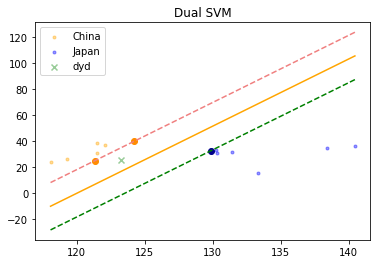

In [ ]:
c1 = plt.scatter(x1[:,0], x1[:,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(x2[:,0], x2[:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(XC[0], XC[1], alpha=0.4, marker='x', c='green')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')


xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
x = np.linspace(xmin, xmax, num=100)
y = -(w[0] * x + b) / w[1]
print(x[:5])
print(y[:5])
plt.plot(x, y,c='orange')

pos_b = - w[0] * pos_sv[0][0] - w[1] * pos_sv[0][1]
pos_f = -(w[0] * x+pos_b) / w[1]
neg_b = - w[0] * neg_sv[0][0] - w[1] * neg_sv[0][1]
neg_f = -(w[0] * x+neg_b) / w[1]

plt.plot(x, pos_f, '--', c='lightcoral')
plt.plot(x, neg_f, '--', c='green')

plt.legend(handles=[c1, c2, c3],labels=['China','Japan','dyd'],loc='best')
plt.title('Dual SVM')


添加内陆城市后

     pcost       dcost       gap    pres   dres
 0: -4.9743e+00 -8.4377e+00  6e+01  9e+00  2e+00
 1: -4.8968e+00 -2.3887e+00  2e+01  3e+00  5e-01
 2: -1.8059e-01 -8.7088e-02  1e+00  1e-01  2e-02
 3: -1.2370e-02 -7.1962e-02  6e-02  6e-17  8e-13
 4: -3.4933e-02 -4.2696e-02  8e-03  5e-18  1e-13
 5: -4.1277e-02 -4.1747e-02  5e-04  3e-18  9e-14
 6: -4.1621e-02 -4.1625e-02  5e-06  1e-17  1e-13
 7: -4.1624e-02 -4.1624e-02  5e-08  7e-18  1e-13
Optimal solution found.
w: [[-0.28323921]
 [ 0.05499059]]
b: [33.98333457]
[118.06       118.28636364 118.51272727 118.73909091 118.96545455]
[-9.89465679 -8.72872895 -7.56280112 -6.39687328 -5.23094544]


Text(0.5, 1.0, 'Dual SVM')

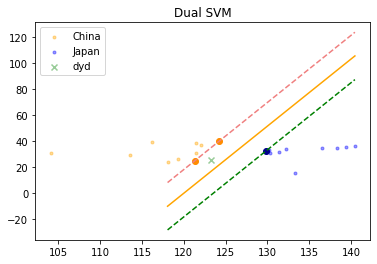

In [ ]:
model2 = DualSVM(dimension=2)
model2.quadratic_programming(xp_train, yp_train)

sv, sv_y = model2.support_vector, model2.support_vector_y
b, w = model2.b, model2.w
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(xp1[:,0], xp1[:,1], alpha=0.4, marker='.', c='orange')
c2 = plt.scatter(xp2[:,0], xp2[:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(XC[0], XC[1], alpha=0.4, marker='x', c='green')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c5 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkorange')
c6 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')


xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
x = np.linspace(xmin, xmax, num=100)
y = -(w[0] * x + b) / w[1]
print(x[:5])
print(y[:5])
plt.plot(x, y,c='orange')

pos_b = - w[0] * pos_sv[0][0] - w[1] * pos_sv[0][1]
pos_f = -(w[0] * x+pos_b) / w[1]
neg_b = - w[0] * neg_sv[0][0] - w[1] * neg_sv[0][1]
neg_f = -(w[0] * x+neg_b) / w[1]

plt.plot(x, pos_f, '--', c='lightcoral')
plt.plot(x, neg_f, '--', c='green')

plt.legend(handles=[c1, c2, c3],labels=['China','Japan','dyd'],loc='best')
#plt.legend(handles=[c1, c3, c2, c4, c5, c6],labels=['1_train','1_test','2_train','2_test','1_sv','2_sv'],loc='best')
plt.title('Dual SVM')

可以看出，内陆城市不影响决策面，因为SVM的决策面仅仅是有支撑向量决定，不管哪种情况，SVM划分的结果钓鱼岛都是属于中国的